# UNO-CG performance evaluation: thermal problem in 2D with periodic BC

### Imports:

In [1]:
import os
import torch
from torch.utils.data import DataLoader
from unocg.utils.data import MicrostructureDataset
from unocg.problems import BC
from unocg.problems.thermal import ThermalProblem
from unocg.materials.thermal import LinearHeatConduction
from unocg.solvers.torch import CgSolver
from unocg.preconditioners.torch import FansPreconditioner, UnoPreconditioner, JacobiPreconditioner
from unocg.transforms.fourier import DiscreteFourierTransform
from unocg.utils.plotting import *
from unocg.utils.evaluation import *
from matplotlib.transforms import Bbox
import time

### Configuration:

In [2]:
show_plots = True
dtype = torch.float64
torch.set_default_dtype(dtype)
quad_degree = 2
bc = BC.PERIODIC
device = "cuda" if torch.cuda.is_available() else "cpu"
args = {'device': device, 'dtype': dtype}
base_path = os.path.abspath(os.path.join(os.path.abspath(""), "..", ".."))
data_path = os.path.abspath(os.path.join(base_path, "data"))
results_path = os.path.abspath(os.path.join(data_path, "results"))
if not os.path.exists(results_path):
    os.makedirs(results_path)

### Define problem

In [3]:
shape = (400, 400)
material = LinearHeatConduction(n_dim=2, **args)
problem = ThermalProblem(shape, material=material, quad_degree=quad_degree, bc=bc)

kappa0, kappa1 = 1.0, 0.2
params = torch.tensor([kappa0, kappa1], **args).reshape(2,1)
loadings = torch.eye(2, **args)[1:]

### Load microstructure from file:

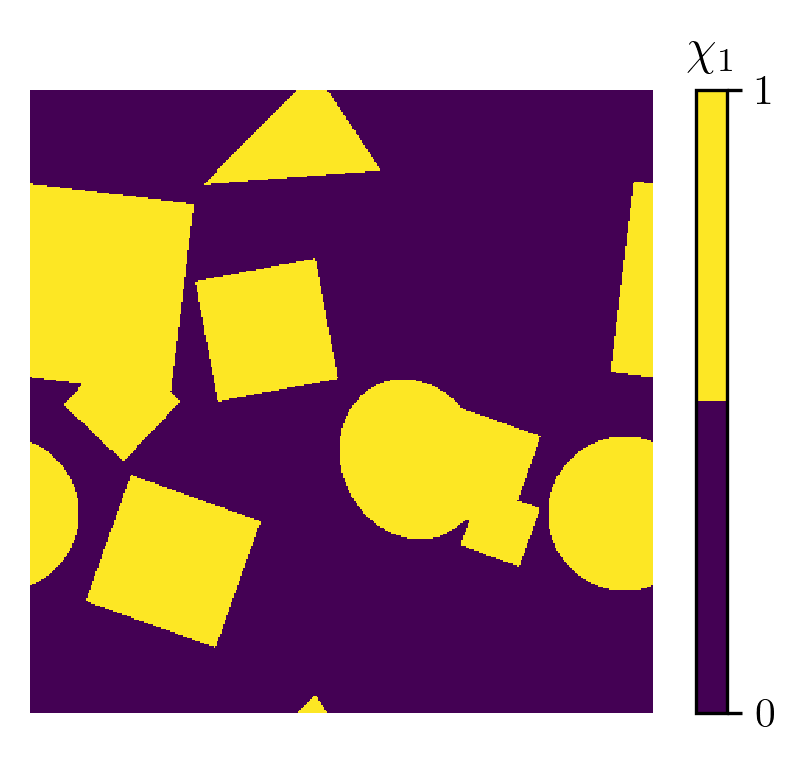

In [4]:
microstructures = MicrostructureDataset(
    file_name=os.path.join(data_path, "2d_microstructures.h5"),
    group_name="test",
    **args
)
data_loader = DataLoader(microstructures, batch_size=400, shuffle=False)
microstructure = microstructures[1]
param_fields = problem.get_param_fields(microstructure.unsqueeze(0), params)

if show_plots:
    plot_ms(microstructure, show_axis=False, show_cbar=True, file=os.path.join(results_path, "2d_microstructure_1.pdf"))

### Compute reference solution using unpreconditioned CG

In [5]:
cg_solver = CgSolver(problem)
print("Computing reference solution using unpreconditioned CG...")
solver_start = time.time()
result_ref = cg_solver.solve(param_fields, loadings, rtol=1e-12)
solver_time = time.time() - solver_start
sol_ref = result_ref['sol']
field_ref = problem.compute_field(result_ref['sol'], param_fields, loadings)
print(f"CG solver converged after {result_ref['n_iter']} iterations and {solver_time:.4f} s")

Computing reference solution using unpreconditioned CG...
CG solver converged after 1956 iterations and 2.4064 s


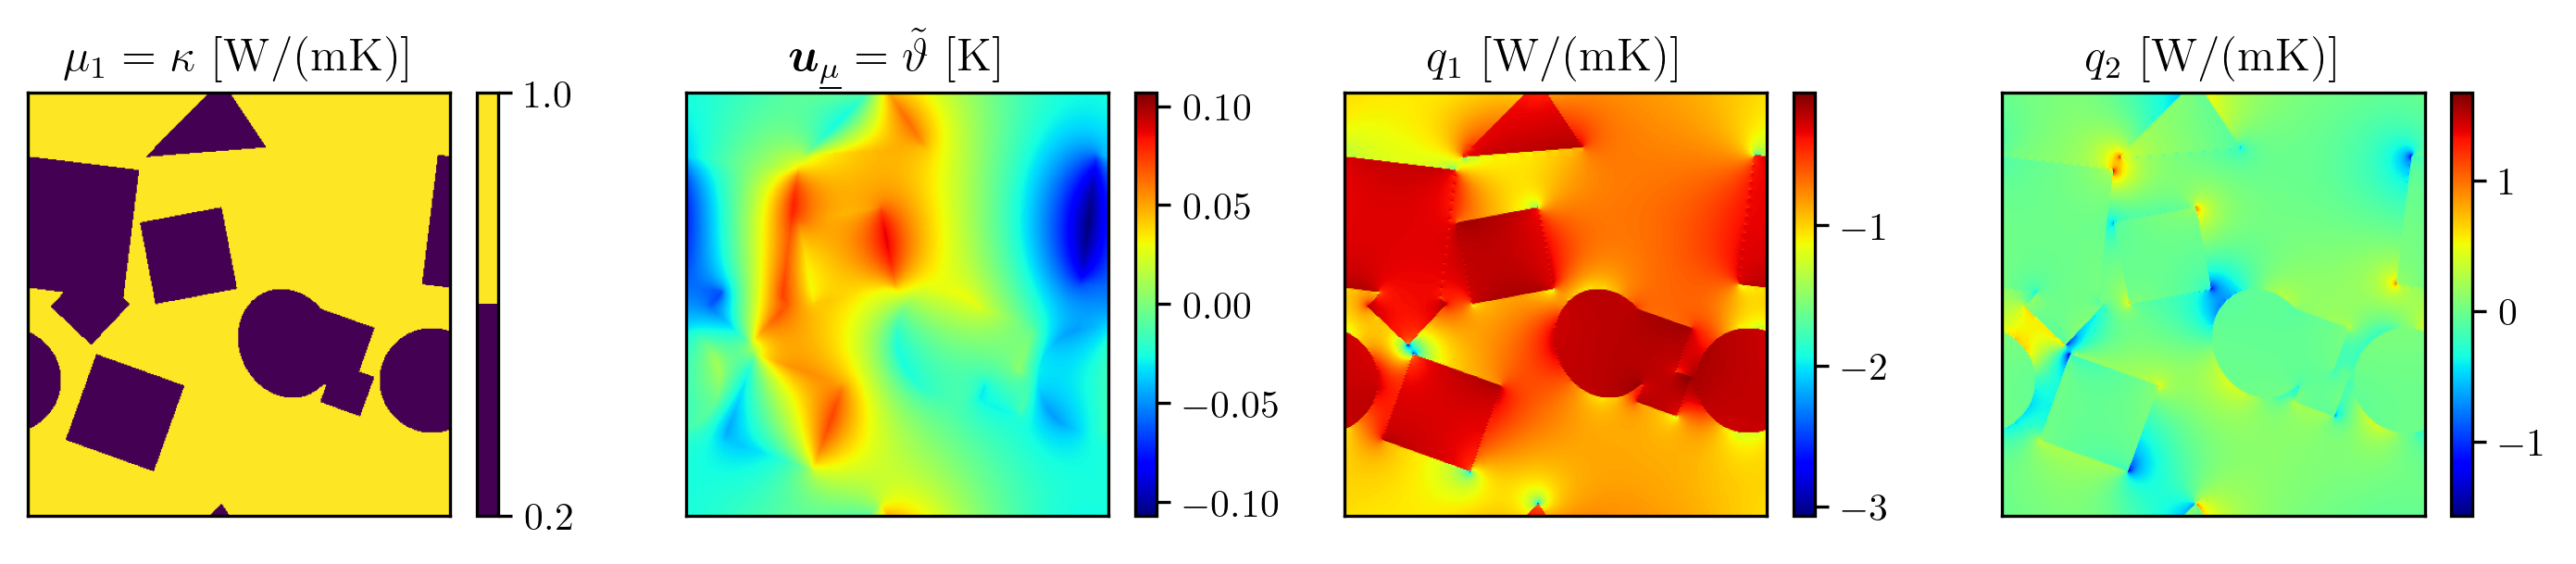

In [6]:
if show_plots:
    temp = field_ref[..., :1, :, :].squeeze(0)
    flux = field_ref[..., 1:, :, :].squeeze(0)
    
    fig, ax = plt.subplots(1, 4, figsize=[plot_width * 1.5, 2.0], dpi=300)
    ms_cmap = plt.get_cmap("viridis", 2)
    cax = ax[0].imshow(param_fields[0,0].cpu(), origin="lower", cmap=ms_cmap)
    ax[0].set_title(r"$\mu_1 = \kappa$ $\mathrm{[W/{(mK)}]}$")
    cb = fig.colorbar(cax, ax=ax[0], ticks=[0.2, 1])
    cax = ax[1].imshow(temp[0,0].cpu(), origin="lower", cmap="jet", norm=matplotlib.colors.CenteredNorm())
    ax[1].set_title(r"$\boldsymbol{u}_{\underline{\mu}} = \tilde{\vartheta}$ $\mathrm{[K]}$")
    fig.colorbar(cax, ax=ax[1])
    cax = ax[2].imshow(flux[0,1].cpu(), origin="lower", cmap="jet")
    ax[2].set_title(r"$q_1$ $\mathrm{[W/{(mK)}]}$")
    fig.colorbar(cax, ax=ax[2])
    cax = ax[3].imshow(flux[0,0].cpu(), origin="lower", cmap="jet")
    ax[3].set_title(r"$q_2$ $\mathrm{[W/{(mK)}]}$")
    fig.colorbar(cax, ax=ax[3])
    for ax_ in ax.ravel():
        ax_.set_xticks([])
        ax_.set_yticks([])
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "results_thermal_2d_per.pdf"), dpi=300)
    plt.show()

### Load learned UNO preconditioners:

In [7]:
weights_uno_naive = torch.load(os.path.join(data_path, "weights_uno_naive_thermal_2d_per.pt"), weights_only=True, map_location=device)
weights_uno = torch.load(os.path.join(data_path, "weights_uno_thermal_2d_per.pt"), weights_only=True, map_location=device)

trafo = DiscreteFourierTransform(dim=[-2, -1])
uno_naive_prec = UnoPreconditioner(problem, trafo, weights_uno_naive)
uno_prec = UnoPreconditioner(problem, trafo, weights_uno)

### Create FANS preconditioner:

In [8]:
params_ref = params.mean()
cond_ref = problem.conductivity(params_ref)
fans_prec = FansPreconditioner(problem, cond_ref)

### Create Jacobi Preconditioner:

In contrast to FANS and UNO, this preconditioner depends on the stiffness matrix, i.e., changes together with the microstructure

In [9]:
A = problem.assemble_matrix(param_fields)
A_diag = problem.sparse_diag(A)
jac_weights = 1.0 / A_diag
jac_prec = JacobiPreconditioner(problem, jac_weights)

### Apply FANS and learned UNO preconditioners on initial residual

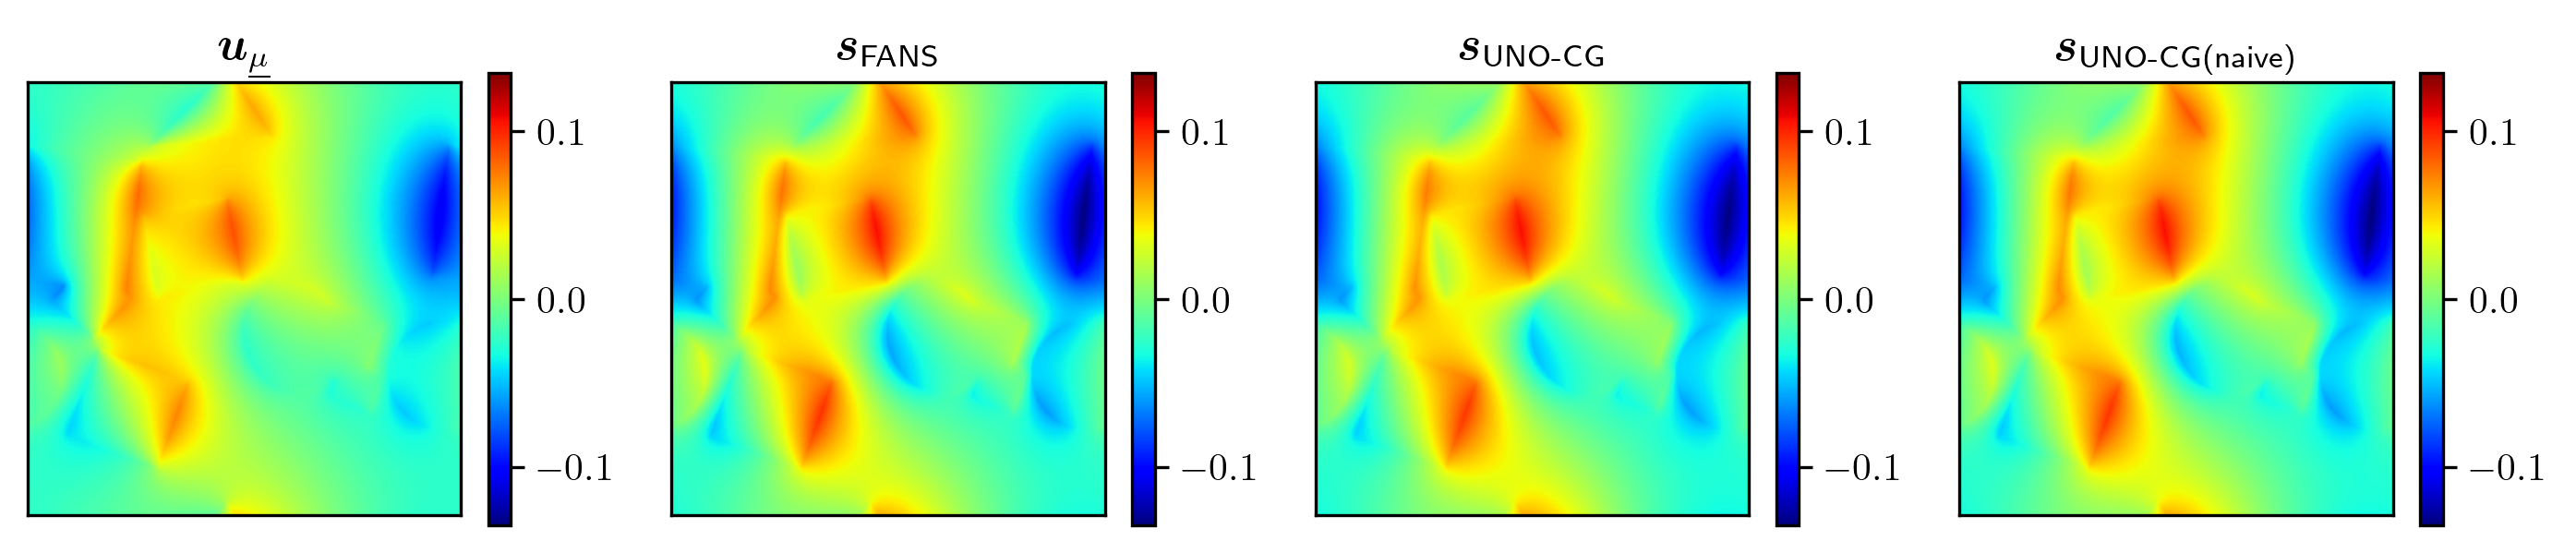

In [10]:
rhs = problem.assemble_rhs(param_fields, loadings)
init_res = problem.reshape_field(rhs)
precs = [fans_prec, uno_prec, uno_naive_prec]
labels = ["FANS", "UNO-CG", "UNO-CG(naive)"]

if show_plots:
    fig, ax = plt.subplots(1, 1 + len(precs), figsize=[plot_width * 1.5, 2.0], dpi=300, squeeze=False)
    plot_prec_action(ax, field_ref, init_res, precs, labels, centered=True)
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "prec_action_thermal_2d_per.pdf"), dpi=300)
    plt.show()

### Run CG method with different preconditioners:

In [11]:
rtol = 1e-11
max_iter = 10000
solver_args = {'rtol': rtol, 'max_iter': max_iter}

def loss_callback(sol):
    field = problem.compute_field(sol, param_fields, loadings)
    return problem.compute_losses(field, field_ref)


fans_solver = CgSolver(problem, fans_prec, **solver_args)
uno_naive_solver = CgSolver(problem, uno_naive_prec, **solver_args)
uno_solver = CgSolver(problem, uno_prec, **solver_args)
jac_solver = CgSolver(problem, jac_prec, **solver_args)
cg_solver = CgSolver(problem, **solver_args)

fans_result = fans_solver.solve(param_fields, loadings, loss_callback=loss_callback)
print(f"FANS converged after {fans_result['n_iter']} iterations")

uno_result = uno_solver.solve(param_fields, loadings, loss_callback=loss_callback)
print(f"UNO-CG converged after {uno_result['n_iter']} iterations")

uno_naive_result = uno_naive_solver.solve(param_fields, loadings, loss_callback=loss_callback)
print(f"UNO-CG (naive) converged after {uno_naive_result['n_iter']} iterations")

jac_result = jac_solver.solve(param_fields, loadings, loss_callback=loss_callback, zero_mean=True)
print(f"Jac-CG converged after {jac_result['n_iter']} iterations")

cg_result = cg_solver.solve(param_fields, loadings, loss_callback=loss_callback)
print(f"CG converged after {cg_result['n_iter']} iterations")

FANS converged after 23 iterations
UNO-CG converged after 35 iterations
UNO-CG (naive) converged after 56 iterations
Jac-CG converged after 1406 iterations
CG converged after 1843 iterations


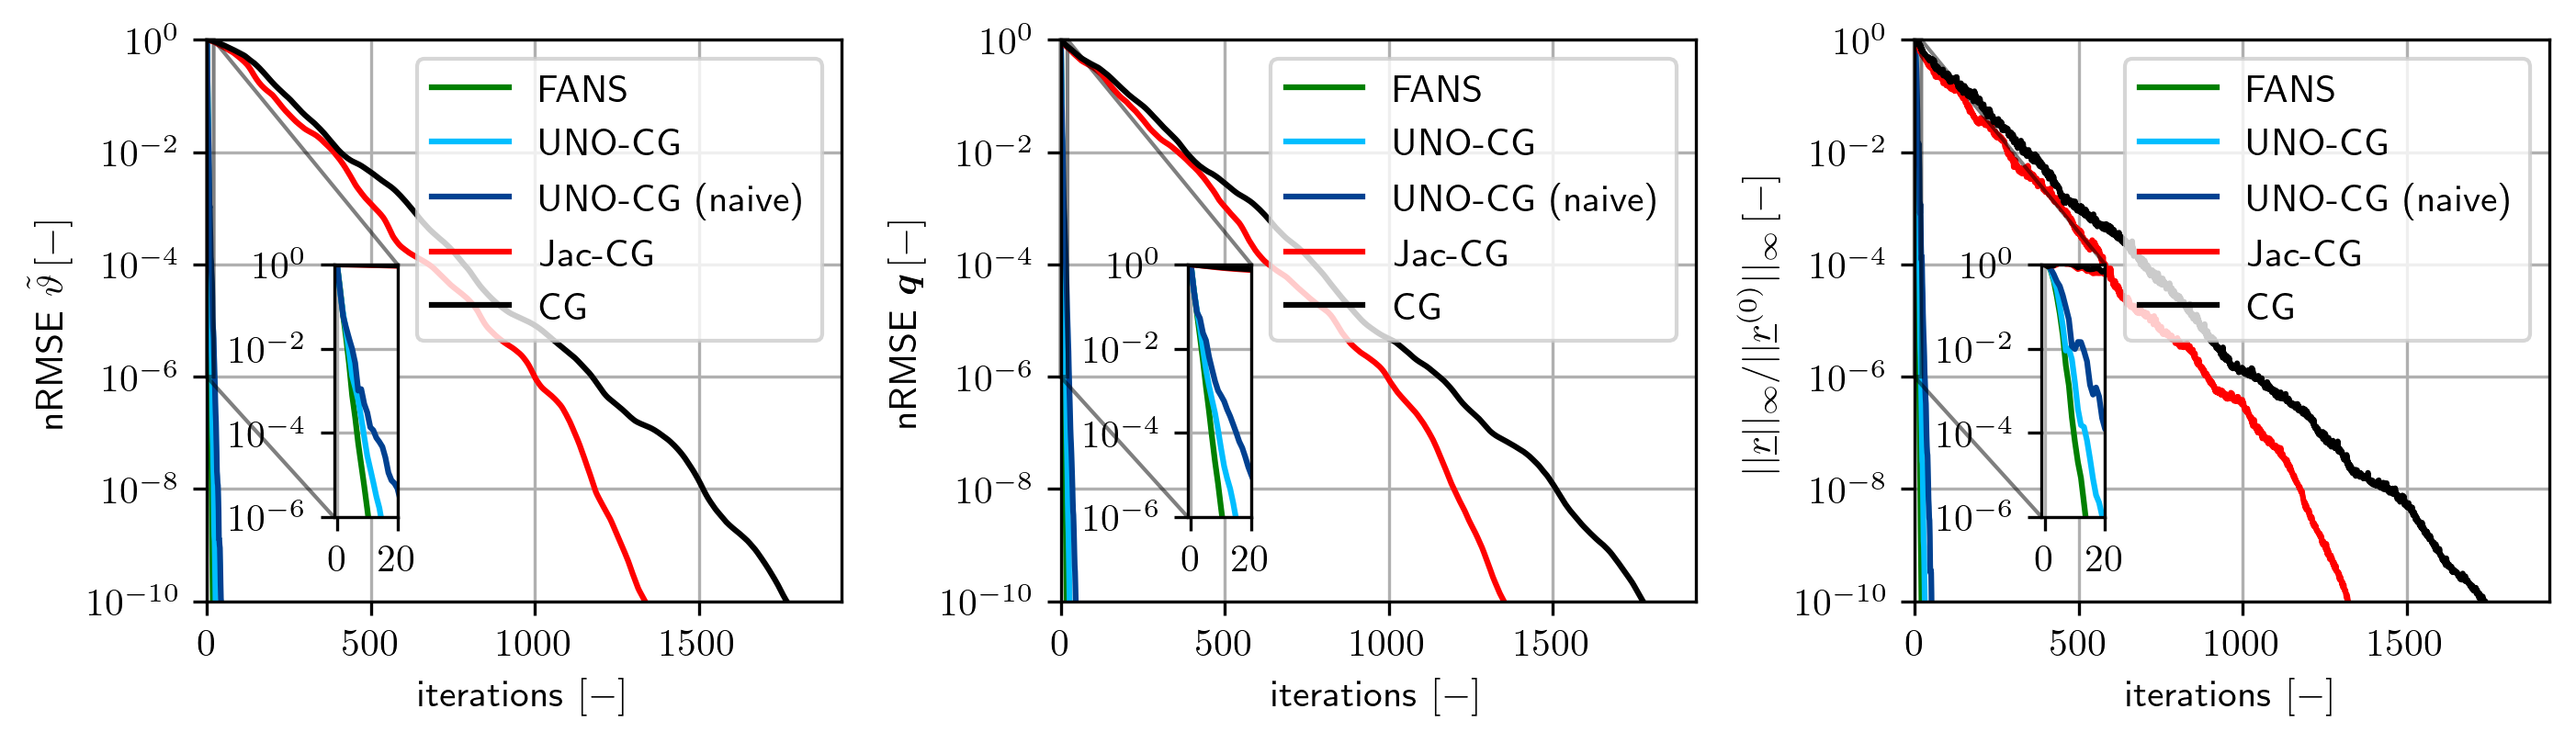

In [12]:
results = [fans_result, uno_result, uno_naive_result, jac_result, cg_result]
labels = ["FANS", "UNO-CG", "UNO-CG (naive)", "Jac-CG", "CG"]
metrics = ["temp", "flux", "res"]
metric_labels = [r"nRMSE $\tilde{\vartheta} \, [-]$",
                 r"nRMSE $\boldsymbol{q} \, [-]$",
                 r"$||\underline{r}||_{\infty} / ||\underline{r}^{(0)}||_{\infty} \, [-]$"]
load_names = ["x"]

for result in results:
    result["losses"]["res"] = result["err_history"].squeeze()

if show_plots:
    fig, ax = plt.subplots(len(load_names), len(metrics), figsize=[plot_width * 1.5, 2.8], dpi=300, squeeze=False, sharex="row", sharey="col")
    plot_convergence(ax.T, results, labels, colors, metrics, metric_labels, load_names=load_names,
                     xmin=0, xmax=None, bounds=False, ymin=1e-10, ymax=1e0, zoom=True, zoom_it=20, zoom_tol=1e-6)
    ax[0,0].legend()
    ax[0,1].legend()
    ax[0,2].legend()
    plt.tight_layout()
    bbox = fig.get_tightbbox()
    bbox = Bbox([[bbox.x0 - 0.05, bbox.y0 - 0.02], [bbox.x1 + 0.05, bbox.y1 + 0.05]])
    plt.savefig(os.path.join(results_path, "convergence_thermal_2d_per.pdf"), dpi=300, bbox_inches=bbox)
    plt.show()

### Runtime measurements

In [13]:
cg_module = cg_solver.get_module(**args, rtol=1e-6)
jac_module = jac_solver.get_module(**args, rtol=1e-6)
fans_module = fans_solver.get_module(**args, rtol=1e-6)
unocg_module = uno_solver.get_module(**args, rtol=1e-6)

In [14]:
benchmark_cg(fans_module, param_fields, loadings, device=device, n_runs=100);

Overall solver:
Runtime per execution: 7.9433ms
Solver iteration:
Runtime per execution: 0.5216ms
Preconditioner application:
Runtime per execution: 0.0935ms
Residual computation:
Runtime per execution: 0.3021ms


In [15]:
benchmark_cg(unocg_module, param_fields, loadings, device=device, n_runs=100);

Overall solver:
Runtime per execution: 11.2655ms
Solver iteration:
Runtime per execution: 0.5236ms
Preconditioner application:
Runtime per execution: 0.0945ms
Residual computation:
Runtime per execution: 0.3028ms


In [16]:
benchmark_cg(jac_module, param_fields, loadings, device=device, n_runs=100);

Overall solver:
Runtime per execution: 402.5811ms
Solver iteration:
Runtime per execution: 0.4312ms
Preconditioner application:
Runtime per execution: 0.0155ms
Residual computation:
Runtime per execution: 0.3024ms


In [17]:
benchmark_cg(cg_module, param_fields, loadings, device=device, n_runs=100);

Overall solver:
Runtime per execution: 457.6117ms
Solver iteration:
Runtime per execution: 0.4249ms
Preconditioner application:
Runtime per execution: 0.0076ms
Residual computation:
Runtime per execution: 0.3019ms


## Robustness study on all test samples

The following evaluation on the entire test data set can take some time depending on the hardware used

In [18]:
microstructure_batch = next(iter(data_loader))
param_batch = problem.get_param_fields(microstructure_batch, params)
print(f"Solving a batch of {param_batch.shape[0]} samples...")

rtol = 1e-7
fans_result_batch = fans_solver.solve(param_batch, rtol=rtol)
print(f"FANS converged after {fans_result_batch['n_iter']} iterations")

uno_result_batch = uno_solver.solve(param_batch, rtol=rtol)
print(f"UNO-CG converged after {uno_result_batch['n_iter']} iterations")

uno_naive_result_batch = uno_naive_solver.solve(param_batch, rtol=rtol)
print(f"UNO-CG (naive) converged after {uno_naive_result_batch['n_iter']} iterations")

cg_result_batch = cg_solver.solve(param_batch, rtol=rtol)
print(f"CG converged after {cg_result_batch['n_iter']} iterations")

Solving a batch of 400 samples...
FANS converged after 20 iterations
UNO-CG converged after 24 iterations
UNO-CG (naive) converged after 40 iterations
CG converged after 1889 iterations


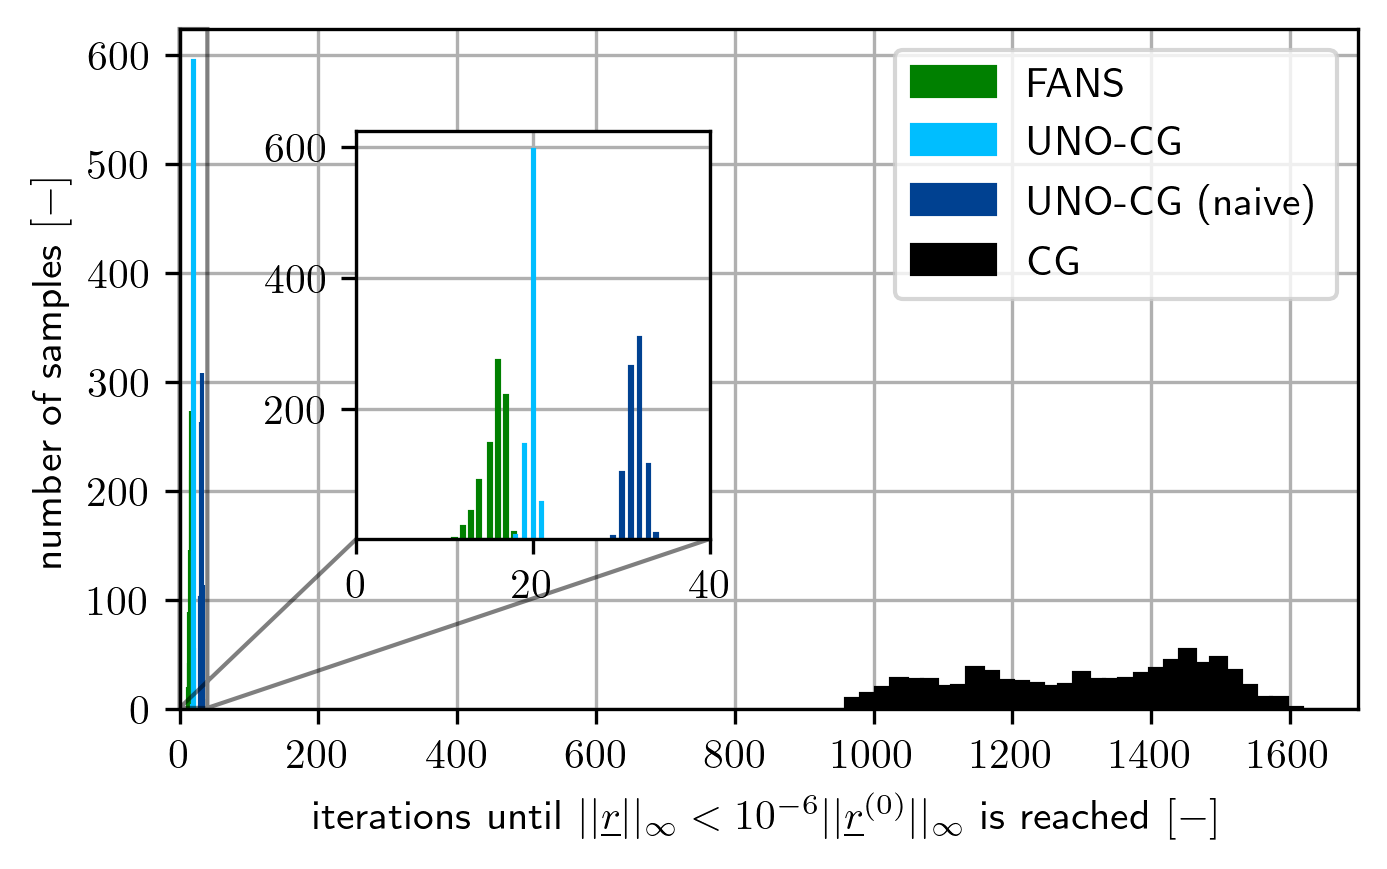

In [19]:
rtol = 1e-6
if show_plots:
    fig, ax = plt.subplots(1, 1, figsize=[plot_width * 0.75, 3.0], dpi=300)
    plot_convergence_histogram(ax, [fans_result_batch, uno_result_batch, uno_naive_result_batch, None, cg_result_batch],
                                   ["FANS", "UNO-CG", "UNO-CG (naive)", None, "CG"], colors=colors,
                                   log_scale=False, xmin=0, xmax=None, rtol=rtol, bins=30)
    x1, x2 = 0, 40
    y1, y2 = 1, ax.get_ylim()[1]
    axins = ax.inset_axes([0.15, 0.25, 0.3, 0.6], xlim=(x1, x2), ylim=(y1, y2))
    plot_convergence_histogram(axins, [fans_result_batch, uno_result_batch, uno_naive_result_batch, None, cg_result_batch],
                                   ["FANS", "UNO-CG", "UNO-CG (naive)", None, "CG"], colors=colors,
                                   log_scale=False, xmin=x1, xmax=x2, rtol=rtol, bins=30)
    axins.get_legend().remove()
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_xlabel(r"iterations until $||\underline{r}||_{\infty} < 10^{-6} ||\underline{r}^{(0)}||_{\infty}$ is reached $[-]$")
    ax.set_ylabel(r"number of samples $[-]$")
    fig.tight_layout()
    plt.savefig(os.path.join(results_path, "convergence_histogram_thermal_2d_per_rtol1e-6.pdf"), dpi=300)
    plt.show()